In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import pingouin as pg
import copy

In [3]:
from datetime import datetime, date, time, timezone, timedelta

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
from scipy import stats
from scipy import sparse

In [5]:
from functools import partial

In [6]:
import mne
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)

In [7]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [9]:
pd.set_option('mode.chained_assignment', None)

In [10]:
%%R
#install.packages("MuMIn", repos='http://cran.us.r-project.org')

NULL


In [11]:
label_fontsize = 16 
title_fontsize = 18

In [12]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [13]:
basefilelist = [#"11072018_SponSleep_LFP"   #-- 1(No calib), 
                 "27072018_SponSleep_LFP",  #-- 2
                 "14092018_SponSleep_LFP",  #-- 3
                 "17092018_SponSleep_LFP",  #-- 4
                #"19092018_SponSleep_LFP",  #-- 5(Noisy calib)
                 "30102018_SponSleep_LFP",  #-- 6
                 "01112018_SponSleep_LFP",  #-- 7
                 "03112018_SponSleep_LFP",  #-- 8
                 "13112018_SponSleep_LFP",  #-- 9 
                #"21112018_SponSleep_LFP",  #-- 10(Very little sleep trials)
                #"22112018_SponSleep_LFP",  #-- 11(Very Noisy calib)
                 "28112018_SponSleep_LFP",  #-- 12(Very little sleep trials)
                #"29112018_SponSleep_LFP",  #-- 13(Inactive after 4 hours)
                 "11122018_SponSleep_LFP",  #-- 14
                 "13122018_SponSleep_LFP",  #-- 15(Very awake fly)
                 "18122018_SponSleep_LFP",  #-- 16
                 "10012019_SponSleep_LFP",  #-- 17
                 "17012019_SponSleep_LFP",  #-- 18
                 "22012019_SponSleep_LFP",  #-- 19
                #"07022019_SponSleep_LFP",  #-- 20(No sleep data)
                 "20022019_SponSleep_LFP",  #-- 21
                #"06032019_SponSleep_LFP",  #-- 22(Noisy calib)
                 "13032019_SponSleep_LFP",  #-- 23
                ]

In [14]:
n_flies = len(basefilelist)
print("Total files considered: " + str(n_flies))

Total files considered: 16


In [15]:
reference = 'neutral' #'neutral','diff'

In [16]:
basefolder = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"

In [17]:
inputfolderpath = basefolder + "drosSleepStages_SciAdvances2023/data/lfp_data/spectrum/"

In [18]:
outputfolderpath = basefolder + "SleepOnset_Drosophila/Scripts/pics/stats_grouplevel/"

In [19]:
inputexampleflypath = inputfolderpath + "/channelgroupspectrum/"
examplefly = "13032019_SponSleep_LFP"

In [20]:
compstrg = 'awakevssleep' #'awakevssleep','earlysleepvsmidsleep'

In [21]:
def plotexamplespectrum(examplefly):
    
    inputfilepath = inputexampleflypath + "Spectrum_channelgroup_" + reference + "_ref_" + examplefly + ".mat"
    print(inputfilepath)
    mat_spectrum = io.loadmat(inputfilepath)

    sleep_size =  np.asscalar(mat_spectrum['cat1_size'])
    awake_size =  np.asscalar(mat_spectrum['cat2_size'])
    
    print('sleep trials#: ', sleep_size)
    print('awake trials#: ', awake_size)

    cat_freqs = mat_spectrum['freqs_state']

    groupchan_sleep_mean = (mat_spectrum['spec_groupchan_cat1_mean'])
    groupchan_awake_mean = (mat_spectrum['spec_groupchan_cat2_mean'])

    groupchan_sleep_se = (mat_spectrum['spec_groupchan_cat1_se'])
    groupchan_awake_se = (mat_spectrum['spec_groupchan_cat2_se'])
    
    return groupchan_awake_mean, groupchan_awake_se, groupchan_sleep_mean, groupchan_sleep_se, cat_freqs

In [22]:
chan_colors = {'central': 'red',
               'middle': 'blue',
               'peripheral': 'green'}

In [23]:
def channelfreqsubplot(axes = None, cat_meanchan_plotlist = None, cat_sechan_plotlist = None,
                       cat_labellist = None, linestyle_list = None,
                       color_list = None, yticklist = None, alphalist = None):
    
    p_list = []
    for plotidx in range(len(cat_meanchan_plotlist)):
        cat_meanchan_plot = cat_meanchan_plotlist[plotidx]
        cat_sechan_plot= cat_sechan_plotlist[plotidx]
        cat_label = cat_labellist[plotidx]
        cat_name = cat_label
        linestyle = linestyle_list[plotidx]
        p_temp, = axes.plot(cat_freqs, cat_meanchan_plot, 
                      alpha=alphalist[plotidx], color=color_list[plotidx], label=cat_label, linestyle=linestyle, 
                      linewidth = 2.0)
        p_list.append(p_temp)
        axes.fill_between(cat_freqs.flatten(), 
                          cat_meanchan_plot - cat_sechan_plot, 
                          cat_meanchan_plot + cat_sechan_plot, 
                          color=color_list,alpha=0.2)
        
    p_temp, = axes.plot([0], marker='None',linestyle='None', label='dummy-tophead')
    p_list.append(p_temp)
        
    yticks = yticklist
    axes.set_yticks(yticks)
    
    axes.set_yticklabels(np.round(yticks,1))
    axes.set_ylim([np.min(yticks)-1, np.max(yticks)+1])
        
    axes.grid(True)
    
    axes.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
    
    xticks = np.arange(5, 45, 5)

    axes.set_xticks(xticks)
    axes.set_xticklabels(np.round(xticks,1))
    axes.set_xlim([np.min(xticks)-1, np.max(xticks)+1])
    
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)

    return axes, p_list 

In [24]:
groupchan_awake_mean, groupchan_awake_se, groupchan_sleep_mean, \
groupchan_sleep_se,cat_freqs = plotexamplespectrum(examplefly)

/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/lfp_data/spectrum//channelgroupspectrum/Spectrum_channelgroup_neutral_ref_13032019_SponSleep_LFP.mat
sleep trials#:  80
awake trials#:  391


In [25]:
groupchan_awake_mean.shape

(145, 3)

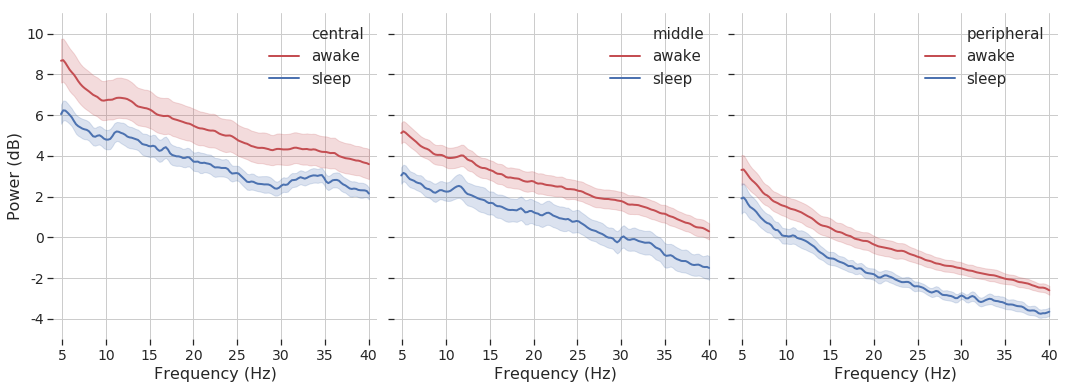

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=False, sharey=True, figsize=(6*3, 6))
fig.subplots_adjust(wspace=0.05, hspace=0)

cat_label_list = ['central']
alphalist = [1]
color_list = ['r']
yticklist = [10, 8, 6, 4, 2, 0, -2, -4]
linestyle_list =['-']


cat_meanchan_plotlist = [groupchan_awake_mean[:,0]]
cat_sechan_plotlist = [groupchan_awake_se[:,0]]
ax1,p1_list = channelfreqsubplot(ax1,cat_meanchan_plotlist,cat_sechan_plotlist,
                         cat_label_list,linestyle_list,color_list,yticklist,alphalist)

ax1.set_xlabel('Frequency (Hz)', fontsize=label_fontsize)
ax1.set_ylabel('Power (dB)',fontsize=label_fontsize, rotation=90)

linestyle_list =['-']

cat_meanchan_plotlist = [groupchan_sleep_mean[:,0]]
cat_sechan_plotlist = [groupchan_sleep_se[:,0]]

color_list = ['b']
ax1,p2_list = channelfreqsubplot(ax1,cat_meanchan_plotlist,cat_sechan_plotlist,
                         cat_label_list,linestyle_list,color_list,yticklist,alphalist)


leg = ax1.legend([p1_list[1], p1_list[0], 
                  p2_list[0]], 
                  cat_label_list + ['awake'] + ['sleep'], 
                  bbox_to_anchor=(1, 1),prop={'size': label_fontsize-1},frameon=False,ncol=1)



cat_label_list = ['middle']
alphalist = [1,]
color_list = ['r']
yticklist = [10, 8, 6, 4, 2, 0, -2, -4]
linestyle_list =['-']


cat_meanchan_plotlist = [groupchan_awake_mean[:,1]]
cat_sechan_plotlist = [groupchan_awake_se[:,1]]
ax2,p1_list = channelfreqsubplot(ax2,cat_meanchan_plotlist,cat_sechan_plotlist,
                         cat_label_list,linestyle_list,color_list,yticklist,alphalist)

ax2.set_xlabel('Frequency (Hz)', fontsize=label_fontsize)
# ax2.set_ylabel('Power (dB)',fontsize=label_fontsize-2, weight = 'bold', rotation=90)

linestyle_list =['-']
color_list = ['b']
cat_meanchan_plotlist = [groupchan_sleep_mean[:,1]]
cat_sechan_plotlist = [groupchan_sleep_se[:,1]]

ax2,p2_list = channelfreqsubplot(ax2,cat_meanchan_plotlist,cat_sechan_plotlist,
                         cat_label_list,linestyle_list,color_list,yticklist,alphalist)


leg = ax2.legend([p1_list[1], p1_list[0], 
                  p2_list[0]], 
                  cat_label_list + ['awake'] + ['sleep'],
                  bbox_to_anchor=(1, 1),prop={'size': label_fontsize-1},frameon=False,ncol=1)


cat_label_list = ['peripheral']
alphalist = [1,]
color_list = ['r']
yticklist = [10, 8, 6, 4, 2, 0, -2, -4]
linestyle_list =['-']

cat_meanchan_plotlist = [groupchan_awake_mean[:,2]]
cat_sechan_plotlist = [groupchan_awake_se[:,2]]
ax3,p1_list = channelfreqsubplot(ax3,cat_meanchan_plotlist,cat_sechan_plotlist,
                         cat_label_list,linestyle_list,color_list,yticklist,alphalist)

ax3.set_xlabel('Frequency (Hz)', fontsize=label_fontsize)
# ax3.set_ylabel('Power (dB)',fontsize=label_fontsize-2, weight = 'bold', rotation=90)

linestyle_list =['-']
color_list = ['b']
cat_meanchan_plotlist = [groupchan_sleep_mean[:,2]]
cat_sechan_plotlist = [groupchan_sleep_se[:,2]]

ax3,p2_list = channelfreqsubplot(ax3,cat_meanchan_plotlist,cat_sechan_plotlist,
                         cat_label_list,linestyle_list,color_list,yticklist,alphalist)


leg = ax3.legend([p1_list[1], p1_list[0], 
                  p2_list[0]], 
                  cat_label_list + ['awake'] + ['sleep'], 
                  bbox_to_anchor=(1, 1),prop={'size': label_fontsize-1},frameon=False,ncol=1)

plt.savefig(outputfolderpath +  'awake_sleep_example_spectogram.png', format='png', dpi=300, transparent=False,
            bbox_inches='tight')

In [27]:
validationfolderpath = basefolder + "drosSleepStages_SciAdvances2023/data/lfp_data/spectrum/" +\
                       "/average/rechours_awakesleep/"

In [28]:
def processvalidationcsv(basefilename):
    
    print('\nProcessing: ', basefilename)
    inputfilepath = validationfolderpath + "Spectrum_CSV_" + reference + "_ref_" + basefilename + ".csv"
    #print('Filepath: ', inputfilepath)
    df_spectrumcsv = pd.read_csv(inputfilepath)
    df_indivvalidcsv = df_spectrumcsv[['start_time', 'end_time', 'state',
                                       "chan01","chan02","chan03","chan04","chan05",
                                       "chan06","chan07","chan08","chan09","chan10",
                                       "chan11","chan12","chan13","chan14","chan15"]]


    df_indivvalidcsv['start_time'] = pd.to_datetime(df_indivvalidcsv['start_time'], format='%d-%b-%Y %H:%M:%S')
    df_indivvalidcsv['end_time'] = pd.to_datetime(df_indivvalidcsv['end_time'], format='%d-%b-%Y %H:%M:%S')

    df_indivvalidcsv['epoch'] = np.nan
    df_indivvalidcsv['boutstart_time'] = np.nan
    df_indivvalidcsv['boutend_time'] = np.nan
    df_indivvalidcsv['rechour'] = np.nan
    
    
    for epochindex, epochrow in df_indivvalidcsv.iterrows():
        if epochindex == 0:
            df_indivvalidcsv.loc[epochindex,'epoch'] = 1
            df_indivvalidcsv.loc[epochindex,'boutstart_time'] = df_indivvalidcsv.loc[epochindex,'start_time']
        else:
            if df_indivvalidcsv.loc[epochindex,'start_time'] == df_indivvalidcsv.loc[epochindex-1,'start_time']:
                df_indivvalidcsv.loc[epochindex,'epoch'] = df_indivvalidcsv.loc[epochindex-1,'epoch']
                df_indivvalidcsv.loc[epochindex,'boutstart_time'] = df_indivvalidcsv.loc[epochindex-1,'boutstart_time']+\
                                                                    timedelta(minutes=1)
            else:
                df_indivvalidcsv.loc[epochindex,'epoch'] = df_indivvalidcsv.loc[epochindex-1,'epoch']+1
                df_indivvalidcsv.loc[epochindex,'boutstart_time'] = df_indivvalidcsv.loc[epochindex,'start_time']
        df_indivvalidcsv.loc[epochindex,'boutend_time'] = df_indivvalidcsv.loc[epochindex,'boutstart_time']+\
                                                            timedelta(minutes=1)
        df_indivvalidcsv.loc[epochindex,'rechour'] = df_indivvalidcsv.loc[epochindex,'boutstart_time'] -\
                                                     np.min(df_indivvalidcsv['start_time'])
        df_indivvalidcsv.loc[epochindex,'rechour'] = np.ceil(df_indivvalidcsv.loc[epochindex,'rechour'].total_seconds()/3600)
        
      
    
    df_indivvalidcsv = df_indivvalidcsv.replace({'rechour': {0: 1}})
    df_indivvalidcsv['boutduration'] = df_indivvalidcsv['boutend_time'] - df_indivvalidcsv['boutstart_time']
    df_indivvalidcsv['boutduration'] = df_indivvalidcsv['boutduration'].dt.total_seconds()
 
    df_indivvalidcsv = df_indivvalidcsv.sort_values('boutstart_time')
    
    print('start_time: ', np.min(df_indivvalidcsv['start_time']))
    print('end_time: ', np.max(df_indivvalidcsv['end_time']))
    
    print('recording duration: ', np.max(df_indivvalidcsv['end_time']) - np.min(df_indivvalidcsv['start_time']))
    
    
    df_indivvalidcsv = df_indivvalidcsv[["chan01","chan02","chan03","chan04","chan05",
                                        "chan06","chan07","chan08","chan09","chan10",
                                        "chan11","chan12","chan13","chan14","chan15",
                                        "state","rechour",\
                                         ]].groupby(['state',\
                                                             'rechour']).agg(['count','mean']).reset_index()
    
    df_indivtrlcsv = df_indivvalidcsv[['state','rechour']]
    
    
    df_indivtrlcsv['chan01'] = df_indivvalidcsv['chan01']['mean']
    df_indivtrlcsv['chan02'] = df_indivvalidcsv['chan02']['mean']
    df_indivtrlcsv['chan03'] = df_indivvalidcsv['chan03']['mean']
    df_indivtrlcsv['chan04'] = df_indivvalidcsv['chan04']['mean']
    df_indivtrlcsv['chan05'] = df_indivvalidcsv['chan05']['mean']
    
    df_indivtrlcsv['chan06'] = df_indivvalidcsv['chan06']['mean']
    df_indivtrlcsv['chan07'] = df_indivvalidcsv['chan07']['mean']
    df_indivtrlcsv['chan08'] = df_indivvalidcsv['chan08']['mean']
    df_indivtrlcsv['chan09'] = df_indivvalidcsv['chan09']['mean']
    df_indivtrlcsv['chan10'] = df_indivvalidcsv['chan10']['mean']
    
    df_indivtrlcsv['chan11'] = df_indivvalidcsv['chan11']['mean']
    df_indivtrlcsv['chan12'] = df_indivvalidcsv['chan12']['mean']
    df_indivtrlcsv['chan13'] = df_indivvalidcsv['chan13']['mean']
    df_indivtrlcsv['chan14'] = df_indivvalidcsv['chan14']['mean']
    df_indivtrlcsv['chan15'] = df_indivvalidcsv['chan15']['mean']
    
    df_indivtrlcsv['count'] = df_indivvalidcsv['chan01']['count']
    
    
    df_indivtrlcsv['flyname'] = basefilename
    
    
    return df_indivtrlcsv


In [29]:
allvalidtrlcsv_df =[]

In [30]:
for basefileidx in range(len(basefilelist)):
        basefilename = basefilelist[basefileidx]
        df_indivtrlcsv  = processvalidationcsv(basefilename)
        allvalidtrlcsv_df.append(df_indivtrlcsv)


Processing:  27072018_SponSleep_LFP
start_time:  2018-07-27 15:13:17
end_time:  2018-07-27 23:12:41
recording duration:  0 days 07:59:24

Processing:  14092018_SponSleep_LFP
start_time:  2018-09-14 14:06:29
end_time:  2018-09-14 22:05:53
recording duration:  0 days 07:59:24

Processing:  17092018_SponSleep_LFP
start_time:  2018-09-17 14:53:24
end_time:  2018-09-17 22:52:48
recording duration:  0 days 07:59:24

Processing:  30102018_SponSleep_LFP
start_time:  2018-10-30 20:42:35
end_time:  2018-10-31 04:41:59
recording duration:  0 days 07:59:24

Processing:  01112018_SponSleep_LFP
start_time:  2018-11-01 20:22:14
end_time:  2018-11-02 04:21:38
recording duration:  0 days 07:59:24

Processing:  03112018_SponSleep_LFP
start_time:  2018-11-03 20:55:45
end_time:  2018-11-04 04:55:09
recording duration:  0 days 07:59:24

Processing:  13112018_SponSleep_LFP
start_time:  2018-11-13 20:19:31
end_time:  2018-11-14 04:18:55
recording duration:  0 days 07:59:24

Processing:  28112018_SponSleep_L

In [31]:
allvalidtrlcsv_df = pd.concat(allvalidtrlcsv_df)

In [32]:
allvalidtrlcsv_df

,state,rechour,chan01,chan02,chan03,chan04,chan05,chan06,chan07,chan08,chan09,chan10,chan11,chan12,chan13,chan14,chan15,count,flyname
,,,,,,,,,,,,,,,,,,,
0,awake,1,8.232582,9.385703,10.088039,10.987308,11.605511,10.765710,10.217268,8.937729,8.285369,7.762352,5.976471,1.962901,3.621153,5.274339,6.973357,37,27072018_SponSleep_LFP
1,awake,2,8.869159,10.333879,10.624331,11.037487,11.536777,10.868097,10.071522,9.798962,9.353651,8.749186,6.762089,1.634096,1.384479,2.703325,3.834766,18,27072018_SponSleep_LFP
2,awake,3,9.559385,10.783494,10.851784,11.135908,11.617878,10.891452,10.351464,10.403564,9.942819,9.246826,6.888299,2.141733,1.337525,3.018194,4.203500,25,27072018_SponSleep_LFP
3,awake,4,9.253107,10.225326,10.229852,10.601747,11.041318,10.356355,9.558533,9.752634,9.330620,8.699405,6.274790,1.636048,0.141087,1.307883,2.031903,25,27072018_SponSleep_LFP
4,awake,5,9.386676,10.286039,10.240382,10.545170,10.892620,10.200320,9.485305,9.616254,9.138496,8.522124,6.210667,1.613425,0.230090,1.483656,2.611672,37,27072018_SponSleep_LFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,awake,8,4.826748,3.975901,3.507249,3.154104,2.490113,1.668136,1.401693,0.760902,-0.037393,-1.060693,-2.355521,-1.627652,-1.703493,-1.748306,-1.349864,26,13032019_SponSleep_LFP
8,sleep,5,5.903139,4.747239,4.210900,3.726659,2.305929,1.819463,2.383343,2.540968,1.545539,-0.175307,-2.424733,-1.490415,-1.055530,-0.814795,-0.346869,15,13032019_SponSleep_LFP
9,sleep,6,5.137401,4.257760,3.825205,3.441716,2.359009,1.837253,2.070334,2.176218,1.243566,-0.348589,-2.576521,-1.515997,-1.229993,-1.041576,-0.642886,8,13032019_SponSleep_LFP


In [33]:
allvalidtrlcsv_df = allvalidtrlcsv_df[allvalidtrlcsv_df['count']>=5]

In [34]:
allvalidtrlcsv_df.columns = allvalidtrlcsv_df.columns.map(''.join)

In [35]:
allvalidtrlcsv_df = allvalidtrlcsv_df.drop('count', axis=1)

In [36]:
allvalidtrlcsv_df

,state,rechour,chan01,chan02,chan03,chan04,chan05,chan06,chan07,chan08,chan09,chan10,chan11,chan12,chan13,chan14,chan15,flyname
0,awake,1,8.232582,9.385703,10.088039,10.987308,11.605511,10.765710,10.217268,8.937729,8.285369,7.762352,5.976471,1.962901,3.621153,5.274339,6.973357,27072018_SponSleep_LFP
1,awake,2,8.869159,10.333879,10.624331,11.037487,11.536777,10.868097,10.071522,9.798962,9.353651,8.749186,6.762089,1.634096,1.384479,2.703325,3.834766,27072018_SponSleep_LFP
2,awake,3,9.559385,10.783494,10.851784,11.135908,11.617878,10.891452,10.351464,10.403564,9.942819,9.246826,6.888299,2.141733,1.337525,3.018194,4.203500,27072018_SponSleep_LFP
3,awake,4,9.253107,10.225326,10.229852,10.601747,11.041318,10.356355,9.558533,9.752634,9.330620,8.699405,6.274790,1.636048,0.141087,1.307883,2.031903,27072018_SponSleep_LFP
4,awake,5,9.386676,10.286039,10.240382,10.545170,10.892620,10.200320,9.485305,9.616254,9.138496,8.522124,6.210667,1.613425,0.230090,1.483656,2.611672,27072018_SponSleep_LFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,awake,8,4.826748,3.975901,3.507249,3.154104,2.490113,1.668136,1.401693,0.760902,-0.037393,-1.060693,-2.355521,-1.627652,-1.703493,-1.748306,-1.349864,13032019_SponSleep_LFP
8,sleep,5,5.903139,4.747239,4.210900,3.726659,2.305929,1.819463,2.383343,2.540968,1.545539,-0.175307,-2.424733,-1.490415,-1.055530,-0.814795,-0.346869,13032019_SponSleep_LFP
9,sleep,6,5.137401,4.257760,3.825205,3.441716,2.359009,1.837253,2.070334,2.176218,1.243566,-0.348589,-2.576521,-1.515997,-1.229993,-1.041576,-0.642886,13032019_SponSleep_LFP
10,sleep,7,4.666292,3.848102,3.376197,3.083647,2.438281,1.782689,1.389159,1.089621,0.214731,-1.139161,-2.823060,-1.853058,-1.691702,-1.711095,-1.249922,13032019_SponSleep_LFP


In [37]:
statsvalid_df = allvalidtrlcsv_df.melt(id_vars=["state", "rechour","flyname"],var_name="channel",
                                       value_name="power")
statsvalid_df

,state,rechour,flyname,channel,power
0,awake,1,27072018_SponSleep_LFP,chan01,8.232582
1,awake,2,27072018_SponSleep_LFP,chan01,8.869159
2,awake,3,27072018_SponSleep_LFP,chan01,9.559385
3,awake,4,27072018_SponSleep_LFP,chan01,9.253107
4,awake,5,27072018_SponSleep_LFP,chan01,9.386676
...,...,...,...,...,...
3190,awake,8,13032019_SponSleep_LFP,chan15,-1.349864
3191,sleep,5,13032019_SponSleep_LFP,chan15,-0.346869
3192,sleep,6,13032019_SponSleep_LFP,chan15,-0.642886
3193,sleep,7,13032019_SponSleep_LFP,chan15,-1.249922


In [38]:
np.unique(statsvalid_df['channel'])

array(['chan01', 'chan02', 'chan03', 'chan04', 'chan05', 'chan06',
       'chan07', 'chan08', 'chan09', 'chan10', 'chan11', 'chan12',
       'chan13', 'chan14', 'chan15'], dtype=object)

In [39]:
np.unique(statsvalid_df['state'])

array(['awake', 'sleep'], dtype=object)

In [40]:
len(np.unique(statsvalid_df['flyname']))

16

In [41]:
%R -i statsvalid_df

In [42]:
%%R
head(statsvalid_df)

  state rechour                flyname channel    power
0 awake       1 27072018_SponSleep_LFP  chan01 8.232582
1 awake       2 27072018_SponSleep_LFP  chan01 8.869159
2 awake       3 27072018_SponSleep_LFP  chan01 9.559385
3 awake       4 27072018_SponSleep_LFP  chan01 9.253107
4 awake       5 27072018_SponSleep_LFP  chan01 9.386676
5 awake       6 27072018_SponSleep_LFP  chan01 8.796325


In [43]:
%%R
df_awakestatsvalid = statsvalid_df[statsvalid_df$state =='awake',]
df_sleepstatsvalid = statsvalid_df[statsvalid_df$state =='sleep',]

In [44]:
%%R
packageVersion("lme4")

[1] ‘1.1.21’


In [45]:
%%R
# Multilevel model with missing values ~ Hierarchical model
# First compare and choose the best model..

library(lmerTest)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [46]:
%%R
head(df_awakestatsvalid)

  state rechour                flyname channel    power
0 awake       1 27072018_SponSleep_LFP  chan01 8.232582
1 awake       2 27072018_SponSleep_LFP  chan01 8.869159
2 awake       3 27072018_SponSleep_LFP  chan01 9.559385
3 awake       4 27072018_SponSleep_LFP  chan01 9.253107
4 awake       5 27072018_SponSleep_LFP  chan01 9.386676
5 awake       6 27072018_SponSleep_LFP  chan01 8.796325


In [47]:
%%R
model.null = lmer(power ~ 1 + (1|flyname), data=df_awakestatsvalid,
                  REML=FALSE)

model.rechour = lmer(power ~ rechour + (1|flyname), data=df_awakestatsvalid,
                  REML=FALSE)

In [48]:
%%R
#compare the null model, with the rechour model..
print(anova(model.null,model.rechour))

Data: df_awakestatsvalid
Models:
model.null: power ~ 1 + (1 | flyname)
model.rechour: power ~ rechour + (1 | flyname)
              Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)  
model.null     3 11879 11896 -5936.5    11873                           
model.rechour  4 11877 11899 -5934.3    11869 4.3637      1    0.03671 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [49]:
%%R
#the above analysis show that the rechour model is the most likely model..
#let's analyse the same..
print(anova(model.rechour))

Type III Analysis of Variance Table with Satterthwaite's method
        Sum Sq Mean Sq NumDF DenDF F value  Pr(>F)  
rechour 120.74  120.74     1  1904  4.3687 0.03674 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [50]:
%%R
library("MuMIn")
r.squaredGLMM(model.rechour)

             R2m       R2c
[1,] 0.001976059 0.1320037


In [51]:
%%R
#the above table shows that there is a main effect of rechour; let's find out more..

NULL


In [52]:
%%R
head(df_awakestatsvalid)

  state rechour                flyname channel    power
0 awake       1 27072018_SponSleep_LFP  chan01 8.232582
1 awake       2 27072018_SponSleep_LFP  chan01 8.869159
2 awake       3 27072018_SponSleep_LFP  chan01 9.559385
3 awake       4 27072018_SponSleep_LFP  chan01 9.253107
4 awake       5 27072018_SponSleep_LFP  chan01 9.386676
5 awake       6 27072018_SponSleep_LFP  chan01 8.796325


In [53]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 
df_awakestatsvalid$staterechour <- interaction(df_awakestatsvalid$rechour, df_awakestatsvalid$state)

model = lmer(power ~ staterechour + (1|flyname), data=df_awakestatsvalid,
             REML=FALSE)

print(summary(glht(model, mcp(staterechour="Tukey"))))

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘TH.data’


R[write to console]: The following object is masked from ‘package:MASS’:

    geyser





	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = power ~ staterechour + (1 | flyname), data = df_awakestatsvalid, 
    REML = FALSE)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)
2.awake - 1.awake == 0 -0.20397    0.47954  -0.425    1.000
3.awake - 1.awake == 0 -0.60866    0.47954  -1.269    0.910
4.awake - 1.awake == 0 -0.16339    0.47954  -0.341    1.000
5.awake - 1.awake == 0 -0.66159    0.47954  -1.380    0.867
6.awake - 1.awake == 0 -0.95428    0.47954  -1.990    0.489
7.awake - 1.awake == 0 -0.86776    0.47954  -1.810    0.613
8.awake - 1.awake == 0 -0.61992    0.47954  -1.293    0.902
3.awake - 2.awake == 0 -0.40469    0.47954  -0.844    0.991
4.awake - 2.awake == 0  0.04059    0.47954   0.085    1.000
5.awake - 2.awake == 0 -0.45762    0.47954  -0.954    0.981
6.awake - 2.awake == 0 -0.75031    0.47954  -1.565    0.772
7.awake - 2.awake == 0 -0.66379    0.47954  -1.384    

In [54]:
%%R
head(df_sleepstatsvalid)

   state rechour                flyname channel    power
8  sleep       1 27072018_SponSleep_LFP  chan01 7.716601
9  sleep       2 27072018_SponSleep_LFP  chan01 8.249757
10 sleep       3 27072018_SponSleep_LFP  chan01 8.667177
11 sleep       4 27072018_SponSleep_LFP  chan01 8.755985
12 sleep       5 27072018_SponSleep_LFP  chan01 8.638436
13 sleep       6 27072018_SponSleep_LFP  chan01 8.169875


In [55]:
%%R
model.null = lmer(power ~ 1 + (1|flyname), data=df_sleepstatsvalid,
                  REML=FALSE)

model.rechour = lmer(power ~ rechour + (1|flyname), data=df_sleepstatsvalid,
                  REML=FALSE)

In [56]:
%%R
#compare the null model, with the rechour model..
print(anova(model.null,model.rechour))

Data: df_sleepstatsvalid
Models:
model.null: power ~ 1 + (1 | flyname)
model.rechour: power ~ rechour + (1 | flyname)
              Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
model.null     3 8017.1 8032.6 -4005.6   8011.1                         
model.rechour  4 8018.7 8039.3 -4005.3   8010.7 0.4593      1     0.4979


In [57]:
statsvalid_df

,state,rechour,flyname,channel,power
0,awake,1,27072018_SponSleep_LFP,chan01,8.232582
1,awake,2,27072018_SponSleep_LFP,chan01,8.869159
2,awake,3,27072018_SponSleep_LFP,chan01,9.559385
3,awake,4,27072018_SponSleep_LFP,chan01,9.253107
4,awake,5,27072018_SponSleep_LFP,chan01,9.386676
...,...,...,...,...,...
3190,awake,8,13032019_SponSleep_LFP,chan15,-1.349864
3191,sleep,5,13032019_SponSleep_LFP,chan15,-0.346869
3192,sleep,6,13032019_SponSleep_LFP,chan15,-0.642886
3193,sleep,7,13032019_SponSleep_LFP,chan15,-1.249922


In [58]:
plotstats_df = statsvalid_df[["state","rechour","flyname","power"]].groupby(['state',
                                  'rechour','flyname']).agg(['mean']).reset_index()
plotstats_df.columns = plotstats_df.columns.map(''.join)
plotstats_df = plotstats_df.rename(columns={'powermean': 'power'})
plotstats_df

,state,rechour,flyname,power
0,awake,1,01112018_SponSleep_LFP,9.271627
1,awake,1,03112018_SponSleep_LFP,8.574488
2,awake,1,10012019_SponSleep_LFP,8.764179
3,awake,1,11122018_SponSleep_LFP,8.188889
4,awake,1,13032019_SponSleep_LFP,3.261800
...,...,...,...,...
208,sleep,8,17092018_SponSleep_LFP,7.957884
209,sleep,8,18122018_SponSleep_LFP,3.191355
210,sleep,8,20022019_SponSleep_LFP,5.404914
211,sleep,8,27072018_SponSleep_LFP,5.909842


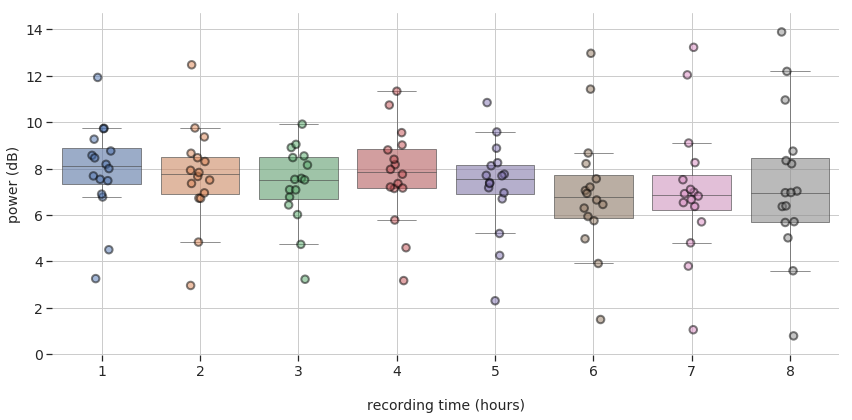

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax = sns.stripplot(x="rechour", y="power", data=plotstats_df[plotstats_df['state']=='awake'],
                   jitter=True, edgecolor ="black",marker='o', s= 7.5, alpha = 0.5,
                   linewidth=2)
g1 = sns.boxplot(x = "rechour", y="power", data=plotstats_df[plotstats_df['state']=='awake'], 
                 showfliers = False)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6)) 
    
    
sns.despine(left=True, bottom = True)


ax.set_ylabel('power (dB)', fontsize=label_fontsize-2)
ax.set_xlabel('\nrecording time (hours)', fontsize=label_fontsize-2)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)

plt.savefig(outputfolderpath + 'awakelfp_rechours.png', format='png', dpi=300, 
             transparent=False, bbox_inches='tight')

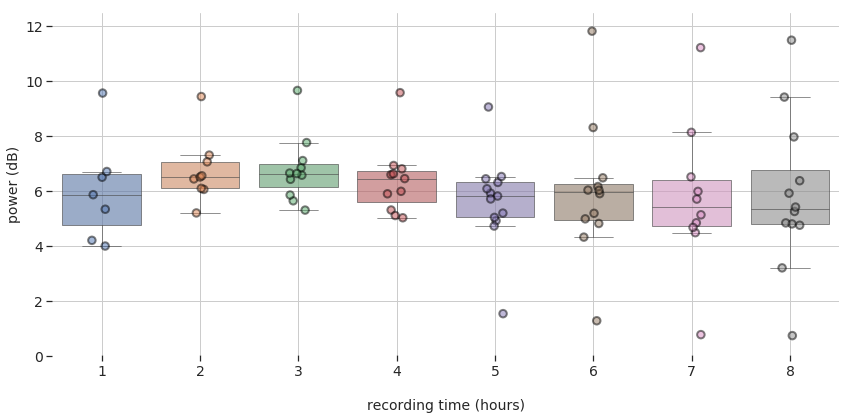

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax = sns.stripplot(x="rechour", y="power", data=plotstats_df[plotstats_df['state']=='sleep'],
                   jitter=True, edgecolor ="black",marker='o', s= 7.5, alpha = 0.5,
                   linewidth=2)
g1 = sns.boxplot(x = "rechour", y="power", data=plotstats_df[plotstats_df['state']=='sleep'], 
                 showfliers = False)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6)) 
    
    
sns.despine(left=True, bottom = True)


ax.set_ylabel('power (dB)', fontsize=label_fontsize-2)
ax.set_xlabel('\nrecording time (hours)', fontsize=label_fontsize-2)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)

plt.savefig(outputfolderpath + 'sleeplfp_rechours.png', format='png', dpi=300, 
             transparent=False, bbox_inches='tight')

In [61]:
mask_freqlims = [7,10] #[7,10],[20,30]

In [62]:
def computegrpdiff(compstrg = 'awakevssleep'):
    
    diff_list = []
    group_cat1 = []
    group_cat2 = []
    group_cat1size = []
    group_cat2size = []
    
    group_roi1_cat1 = []
    group_roi1_cat2 = []
    group_roi2_cat1 = []
    group_roi2_cat2 = []
    group_roi3_cat1 = []
    group_roi3_cat2 = []
    
    for basefileidx in range(len(basefilelist)):
        basefilename = basefilelist[basefileidx]
        print('Processing: ', basefilename)
    
        inputfilepath = inputfolderpath + "/average/awakesleep/" + "Spectrum_" + reference + "_ref_" + basefilename + ".mat"
        print('Filepath: ', inputfilepath)
        mat_spectrum = io.loadmat(inputfilepath)
        
        cat_awake_mean =         (mat_spectrum['chan_awake_mean'])
        cat_intrans_mean =       (mat_spectrum['chan_intrans_mean'])
        cat_sleep_mean =         (mat_spectrum['chan_sleep_mean'])
        cat_earlysleep_mean =    (mat_spectrum['chan_earlysleep_mean'])
        cat_earlymidsleep_mean = (mat_spectrum['chan_earlymidsleep_mean'])
        cat_midsleep_mean =      (mat_spectrum['chan_midsleep_mean'])
        cat_latemidsleep_mean =  (mat_spectrum['chan_latemidsleep_mean'])
        cat_latesleep_mean =     (mat_spectrum['chan_latesleep_mean'])
        
        chan_awake_se =         (mat_spectrum['chan_awake_se'])
        chan_intrans_se =       (mat_spectrum['chan_intrans_se'])
        chan_sleep_se =         (mat_spectrum['chan_sleep_se'])
        chan_earlysleep_se =    (mat_spectrum['chan_earlysleep_se'])
        chan_earlymidsleep_se = (mat_spectrum['chan_earlymidsleep_se'])
        chan_midsleep_se =      (mat_spectrum['chan_midsleep_se'])
        chan_latemidsleep_se =  (mat_spectrum['chan_latemidsleep_se'])
        chan_latesleep_se =     (mat_spectrum['chan_latesleep_se'])
        
        awake_size =         np.asscalar(mat_spectrum['awake_size'])
        intrans_size =       np.asscalar(mat_spectrum['intrans_size'])
        sleep_size =         np.asscalar(mat_spectrum['sleep_size'])
        earlysleep_size =    np.asscalar(mat_spectrum['earlysleep_size'])
        earlymidsleep_size = np.asscalar(mat_spectrum['earlymidsleep_size'])
        midsleep_size =      np.asscalar(mat_spectrum['midsleep_size'])
        latemidsleep_size =  np.asscalar(mat_spectrum['latemidsleep_size'])
        latesleep_size =     np.asscalar(mat_spectrum['latesleep_size'])
        
        cat_freqs = mat_spectrum['freqs_state']
#         cat_allstate = np.hstack(mat_spectrum['state'].flatten()).tolist()
    
        
        if compstrg == 'awakevssleep':
            
            mintrials = 10
            cat1_mean = cat_sleep_mean
            cat2_mean = cat_awake_mean 
            cat1_size = sleep_size
            cat2_size = awake_size
            cat1_strg = 'sleep'
            cat2_strg = 'awake'
            cat_state =[cat1_strg,cat2_strg]
            mask1_chanlims = [0,4] #[0,1]
            mask2_chanlims = [5,9]
            mask3_chanlims = [10,14]
            
            mask1_freqlims = mask_freqlims #[4,5]
            mask2_freqlims = mask_freqlims
            mask3_freqlims = mask_freqlims
            
            
        elif compstrg == 'earlysleepvsmidsleep':
            mintrials = 5
            cat1_mean = cat_earlysleep_mean
            cat2_mean = cat_midsleep_mean 
            cat1_size = earlysleep_size
            cat2_size = midsleep_size
            cat1_strg = 'earlysleep'
            cat2_strg = 'midsleep'
            cat_state =[cat1_strg,cat2_strg]
            mask1_freqlims = [7,10]
            mask2_freqlims = [20,23]
            mask1_chanlims = [3,5]
            mask2_chanlims = [5,8]
            
        elif compstrg == 'earlysleepvslatesleep':
            mintrials = 5
            cat1_mean = cat_earlysleep_mean
            cat2_mean = cat_latesleep_mean 
            cat1_size = earlysleep_size
            cat2_size = latesleep_size
            cat1_strg = 'earlysleep'
            cat2_strg = 'latesleep'
            cat_state =[cat1_strg,cat2_strg]
            mask1_freqlims = [7,10]
            mask2_freqlims = [20,23]
            mask1_chanlims = [3,5]
            mask2_chanlims = [5,8]
            
            
        mask1_freq = (cat_freqs.flatten() >= mask1_freqlims[0]) & (cat_freqs.flatten() <=mask1_freqlims[1])
        mask2_freq = (cat_freqs.flatten() >= mask2_freqlims[0]) & (cat_freqs.flatten() <=mask2_freqlims[1])
        mask3_freq = (cat_freqs.flatten() >= mask3_freqlims[0]) & (cat_freqs.flatten() <=mask3_freqlims[1])
    
    
        chan_idx = np.arange(1,16)
        mask1_chans = (chan_idx.flatten() >= mask1_chanlims[0]) & (chan_idx.flatten() <=mask1_chanlims[1])
        mask2_chans = (chan_idx.flatten() >= mask2_chanlims[0]) & (chan_idx.flatten() <=mask2_chanlims[1])
        mask3_chans = (chan_idx.flatten() >= mask3_chanlims[0]) & (chan_idx.flatten() <=mask3_chanlims[1])
        
            
        roi1_cat1 = cat1_mean[mask1_freq][:,mask1_chans]
        roi1_cat1mean = np.mean(roi1_cat1)
        roi1_cat2 = cat2_mean[mask1_freq][:,mask1_chans]
        roi1_cat2mean = np.mean(roi1_cat2)
    
        roi2_cat1 = cat1_mean[mask2_freq][:,mask2_chans]
        roi2_cat1mean = np.mean(roi2_cat1)
        roi2_cat2 = cat2_mean[mask2_freq][:,mask2_chans]
        roi2_cat2mean = np.mean(roi2_cat2)
        
        roi3_cat1 = cat1_mean[mask3_freq][:,mask3_chans]
        roi3_cat1mean = np.mean(roi3_cat1)
        roi3_cat2 = cat2_mean[mask3_freq][:,mask3_chans]
        roi3_cat2mean = np.mean(roi3_cat2)
            
        if len(cat1_mean)>0 and len(cat2_mean)>0:
        
            print("Cat1: ", cat1_strg,  " -- size: " + str(cat1_size))
            print("Cat2: ", cat2_strg,  " -- size: " + str(cat2_size))

            if cat1_size >=mintrials and cat2_size >= mintrials:
                diff_cat = cat1_mean - cat2_mean
                diff_list.append(diff_cat)
                group_cat1.append(cat1_mean)
                group_cat2.append(cat2_mean)
                group_cat1size.append(cat1_size)
                group_cat2size.append(cat2_size)
                
                group_roi1_cat1.append(roi1_cat1mean)
                group_roi1_cat2.append(roi1_cat2mean)
                group_roi2_cat1.append(roi2_cat1mean)
                group_roi2_cat2.append(roi2_cat2mean)
                group_roi3_cat1.append(roi3_cat1mean)
                group_roi3_cat2.append(roi3_cat2mean)
                
            else:
                print("Skipping: " + "Spectrum_" + reference + "_ref_" + basefilelist[0] + ".mat")
        else:
            print("Skipping: " + "Spectrum_" + reference + "_ref_" + basefilelist[0] + ".mat")
            
    
    diff_group = np.array(diff_list)
    group_cat1 = np.array(group_cat1)
    group_cat2 = np.array(group_cat2)
    group_cat1size = np.array(group_cat1size)
    group_cat2size = np.array(group_cat2size)
    
    return diff_group,group_cat1,group_cat2,group_cat1size,group_cat2size,cat_freqs,\
           cat_state,group_roi1_cat1,group_roi1_cat2,group_roi2_cat1,group_roi2_cat2,\
           group_roi3_cat1,group_roi3_cat2

In [63]:
#here, intrans is also added to awake(already)..

In [64]:
diff_group,group_cat1,group_cat2,group_cat1size,group_cat2size,cat_freqs,cat_state,\
           group_roi1_cat1,group_roi1_cat2,\
           group_roi2_cat1,group_roi2_cat2,\
           group_roi3_cat1,group_roi3_cat2 = computegrpdiff(compstrg = compstrg)

Processing:  27072018_SponSleep_LFP
Filepath:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/lfp_data/spectrum//average/awakesleep/Spectrum_neutral_ref_27072018_SponSleep_LFP.mat
Cat1:  sleep  -- size: 184
Cat2:  awake  -- size: 281
Processing:  14092018_SponSleep_LFP
Filepath:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/lfp_data/spectrum//average/awakesleep/Spectrum_neutral_ref_14092018_SponSleep_LFP.mat
Cat1:  sleep  -- size: 164
Cat2:  awake  -- size: 300
Processing:  17092018_SponSleep_LFP
Filepath:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/lfp_data/spectrum//average/awakesleep/Spectrum_neutral_ref_17092018_SponSleep_LFP.mat
Cat1:  sleep  -- size: 256
Cat2:  awake  -- size: 207
Processing:  30102018_SponSleep_LFP
Filepath:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttent

In [65]:
group_cat1mean = np.average(group_cat1, axis = 0, weights = group_cat1size)

In [66]:
group_cat2mean = np.average(group_cat2, axis = 0, weights = group_cat2size)

In [67]:
diff_groupmean = np.mean(diff_group, axis = 0)
diff_groupmean.shape

(145, 15)

In [68]:
n_flies = diff_group.shape[0]
print('number of flies considered: ', str(n_flies))

number of flies considered:  16


In [69]:
def plot_spect(data, ax, x, y, x_label, y_label, cbar_label, title, vmin = None, vmax = None):
    
    im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
    
    y_mod = np.concatenate(y)
    freqs_plot = [5, 10, 15, 20, 25, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    
    ytickvals = np.around(np.concatenate(y[yticklocs]))
    
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    ax.set_xlim([0, np.asarray(x.shape)-1])
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    plt.xticks(xticklocs, tickval)
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=20, labelpad=20)
    ax.set_ylabel(y_label, rotation=90,ha='center',va='center', fontsize=20, labelpad=20)
    
    ax.invert_yaxis()

    #plt.colorbar(im)
    
    cbarticks = np.linspace(vmin, vmax, 5, endpoint=True)
    cbarticks = np.round(cbarticks,2)
    
    cbar = fig.colorbar(im, ax=ax, ticks = cbarticks)
    cbar.ax.set_ylabel(cbar_label, rotation=90, fontsize=20, labelpad=20)
    
    plt.title(title,ha='center',va='bottom', fontsize=20)
    
    cbar.ax.tick_params(labelsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return ax

In [70]:
if compstrg == 'awakevssleep':
    grpvmax = 15   #20,10,15
    grpvmin = 0 #-5,-2,-2.5
    diffvmax =  2  #0.2,np.round(np.max(diff_groupmean))
    diffvmin = -2  #-0.2,np.round(np.min(diff_groupmean)
                      
elif compstrg == 'earlysleepvsmidsleep':
    grpvmax = 15   #20,10
    grpvmin = -2.5 #-5,-2
    diffvmax =  2  #0.2,np.round(np.max(diff_groupmean))
    diffvmin = -2  #-0.2,np.round(np.min(diff_groupmean)
    
elif compstrg == 'earlysleepvslatesleep':
    grpvmax = 15   #20,10
    grpvmin = -2.5 #-5,-2
    diffvmax =  2  #0.2,np.round(np.max(diff_groupmean))
    diffvmin = -2  #-0.2,np.round(np.min(diff_groupmean)

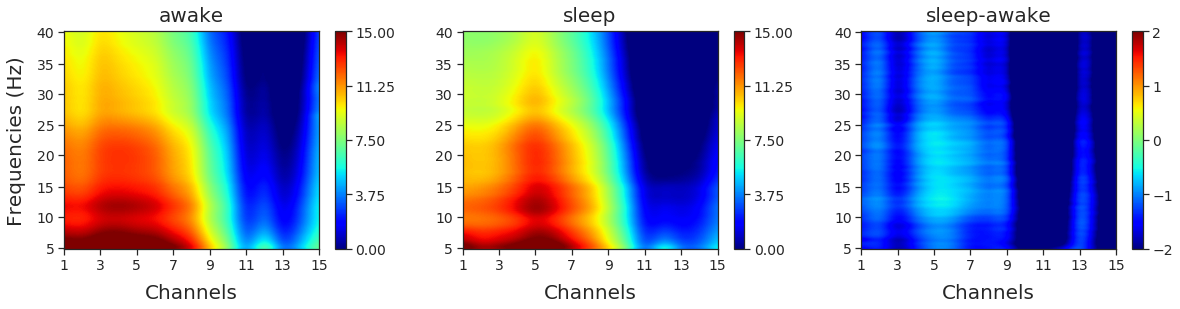

In [71]:
fig = plt.figure(figsize=(20, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(group_cat2mean, ax = ax1, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', 
                 cbar_label = '',
                 title = cat_state[1],
                 vmin = grpvmin, vmax = grpvmax)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_spect(group_cat1mean, ax = ax2, x = np.arange(0,group_cat1.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', 
                 cbar_label = '',
                 title = cat_state[0],
                 vmin = grpvmin, vmax = grpvmax)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax3 = fig.add_subplot(gs[0])
ax3 = plot_spect(diff_groupmean, ax = ax3, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                 x_label = 'Channels',y_label = '', 
                 cbar_label = '',
                 title = cat_state[0] + '-' + cat_state[1],
                 vmin = diffvmin, vmax = diffvmax)

In [72]:
X = copy.deepcopy(diff_group)
X.shape

(16, 145, 15)

In [73]:
temp_flies, temp_freq, temp_chan  = X.shape
n_src = temp_freq*temp_chan
X.shape = (n_flies, n_src)  # flatten the array for simplicity

In [74]:
maxperm = permutation_t_test(X, verbose=False)[:2]

In [75]:
# connectivity matrix contains zeros and ones to define which spatial points are connected, 
# i.e., which electrodes are adjacent to each other

In [76]:
                           #1 2  3  4  5  6  7  8  9  10 11 12 13 14 15,
connectivity =  np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#1
                          [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#2
                          [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#3
                          [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#4
                          [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],#5
                          [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],#6
                          [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],#7
                          [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],#8
                          [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],#9
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],#10
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],#11
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],#12
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],#13
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],#14
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]) #15

In [77]:
conn_sparse=sparse.csr_matrix(connectivity)

In [78]:
alpha = 0.05
n_permutations = 'all'
threshold = -stats.distributions.t.ppf(alpha / 2., n_flies - 1)

In [79]:
sigma = 1e-3  # sigma for the "hat" method

In [80]:
stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)
t_hat, clusters, p_values, H0 = permutation_cluster_1samp_test(
                                    diff_group, n_jobs=1, threshold=threshold, adjacency=conn_sparse,
                                    n_permutations=n_permutations, stat_fun=stat_fun_hat, buffer_size=None)

stat_fun(H1): min=-7.687862 max=-3.080230
Running initial clustering
Found 1 clusters
Permuting 32766 times...



Computing cluster p-values
Done.


In [81]:
p_hat = np.ones((temp_freq, temp_chan))
for cl, p in zip(clusters, p_values):
    p_hat[cl] = p

In [82]:
contourmask = np.where(p_hat<0.05, 1, 0)
mask = np.where(p_hat<0.05, 1, np.nan)

In [83]:
def plot_clustermask(data, ax, x, y, x_label, y_label, title, contourmask = None, mask = None, 
                     vmin = None, vmax = None, cmap = 'jet'):
    
    
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    
    
    if mask is not None:
        
        extent = [-0.55, len(x)-0.55, -0.55, len(y)-0.55]  
        im_args = dict(interpolation='nearest', origin='lower',extent=extent, aspect='auto', vmin=vmin, vmax=vmax)
        
        
        big_mask = np.kron(contourmask, np.ones((10, 10)))
        ax.contour(big_mask, colors=["black"], extent=extent,linewidths=[.5], corner_mask=False,antialiased=True, levels=[0.5])
        masked_data = data*mask

        im1 = ax.imshow(masked_data,aspect='auto',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax, alpha = 0.5)
        
        #cbar  = fig.colorbar(im1, ax=ax)
        
        cbarticks = np.linspace(vmin, vmax, 5, endpoint=True)
        cbarticks = np.round(cbarticks,2)
    
        cbar = fig.colorbar(im1, ax=ax, ticks = cbarticks)

    else:
        im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
        
        
    y_mod = np.concatenate(y)
    freqs_plot = [5, 10, 15, 20, 25, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    

    ytickvals = np.around(np.concatenate(y[yticklocs]))
    
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
        
    ax.set_xlim([0, np.asarray(x.shape)-1])
    
    ax.invert_yaxis()

    ax.set_xticks(xticklocs)
    ax.set_xticklabels(tickval)
    
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=20, labelpad=20)
    ax.set_ylabel(y_label, rotation=90,ha='center',va='center', fontsize=20, labelpad=20)
    
    plt.title(title,ha='center',va='bottom', fontsize=20)
    
    
    
    cbar.ax.tick_params(labelsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
   
    return ax

In [84]:
def plot_pvalues(fig, ax, x, y, x_label, y_label, title, cmap = 'jet'):
    
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    
    p_plot = np.squeeze(np.asarray(maxperm[1]))
    
    p_plot.shape = (temp_freq, temp_chan)
    
    p_lims = [0.05, 0.001]
    p_lims = [-np.log10(p) for p in p_lims]
    
    # p plot
    im2 = ax.imshow(-np.log10(p_plot),aspect='auto',interpolation='spline36',cmap=cmap,
                    vmin=p_lims[0], vmax=p_lims[1])
    
    y_mod = np.concatenate(y)
    freqs_plot = [5, 10, 15, 20, 25, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    

    ytickvals = np.around(np.concatenate(y[yticklocs]))
    
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
    
    ax.invert_yaxis()
    
    ax.set_xticks(xticklocs)
    ax.set_xticklabels(tickval)
    ax.set_xlim([0, np.asarray(x.shape)-1])
    
    cbarticks = np.linspace(p_lims[0], p_lims[1], 5, endpoint=True)
    cbarticks = np.round(cbarticks,2)
    
    cbar = fig.colorbar(im2, ax=ax, ticks = cbarticks)
    
    cbar.set_label(r'$-\log_{10}(p)$', fontsize=20)
    
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=20, labelpad=20)    
    plt.title(title,ha='center',va='bottom', fontsize=20)
    
    cbar.ax.tick_params(labelsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    return ax

In [85]:
group_means = np.mean(diff_group*-1, axis=0) #to invert the effect size to be meaningful
group_stds = np.std(diff_group, axis=0)

cohens_d = group_means/group_stds

In [86]:
cohens_d.shape

(145, 15)

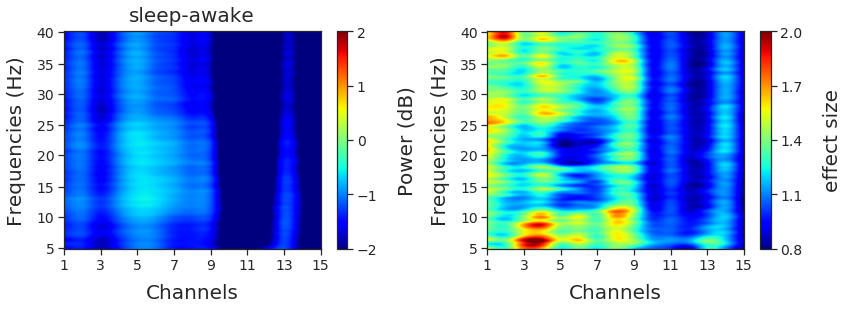

In [88]:
fig = plt.figure(figsize=((20/3)*2, 4))
gs_main = gridspec.GridSpec(1, 2,width_ratios=[4,4])
gs_main.update(wspace=0.32, hspace=0.2)


gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(diff_groupmean, ax = ax1, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                 x_label = 'Channels',y_label = 'Frequencies (Hz)',
                 cbar_label = 'Power (dB)',
                 title = cat_state[0] + '-' + cat_state[1],
                 vmin = diffvmin, vmax = diffvmax)


gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])

ax2 = plot_spect(cohens_d, ax = ax2, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)',
                 cbar_label = 'effect size',
                 title = '',
                 vmin = 0.8, vmax = 2)

# plt.savefig(outputfolderpath +  'awake_sleep_spectogram_stats.png', format='png', dpi=300, 
#             transparent=False,bbox_inches='tight')

In [89]:
group_roi1_df = pd.DataFrame({cat_state[1]: group_roi1_cat2, cat_state[0]: group_roi1_cat1})
group_roi1_df['dataset'] = group_roi1_df.index
group_roi1_df = group_roi1_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [90]:
resroi1_df = pg.pairwise_ttests(dv='power', within = 'type', subject='dataset', effsize = 'cohen', 
                              data=group_roi1_df)
resroi1_df

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,type,awake,sleep,True,True,6.072475,15.0,two-sided,0.000021,1122.648,0.595426


In [91]:
group_roi2_df = pd.DataFrame({cat_state[1]: group_roi2_cat2, cat_state[0]: group_roi2_cat1})
group_roi2_df['dataset'] = group_roi2_df.index
group_roi2_df = group_roi2_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [92]:
resroi2_df = pg.pairwise_ttests(dv='power', within = 'type', subject='dataset', effsize = 'cohen',
                              data=group_roi2_df)
resroi2_df

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,type,awake,sleep,True,True,6.593883,15.0,two-sided,0.000009,2552.34,0.46056


In [93]:
group_roi3_df = pd.DataFrame({cat_state[1]: group_roi3_cat2, cat_state[0]: group_roi3_cat1})
group_roi3_df['dataset'] = group_roi3_df.index
group_roi3_df = group_roi3_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [94]:
resroi3_df = pg.pairwise_ttests(dv='power', within = 'type', subject='dataset', effsize = 'cohen',
                              data=group_roi3_df)
resroi3_df

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,type,awake,sleep,True,True,4.433984,15.0,two-sided,0.000483,71.809,0.745742


In [95]:
typepal = {cat_state[1]:'r', cat_state[0]: 'b'}

In [96]:
from statannot import add_stat_annotation

In [97]:
def statannotation(ax, x1, x2, y,text):
    h = 0.5
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

In [98]:
t_stat1 = resroi1_df['T'].values[0]
p_val1 = resroi1_df['p-unc'].values[0]
df_test1 = resroi1_df['dof'].values[0]
cohens_d1 = resroi1_df['cohen'].values[0]
bf_val1 = resroi1_df['BF10'].values[0]

In [99]:
t_stat2 = resroi2_df['T'].values[0]
p_val2 = resroi2_df['p-unc'].values[0]
df_test2 = resroi2_df['dof'].values[0]
cohens_d2 = resroi2_df['cohen'].values[0]
bf_val2 = resroi2_df['BF10'].values[0]

In [100]:
t_stat3 = resroi3_df['T'].values[0]
p_val3 = resroi3_df['p-unc'].values[0]
df_test3 = resroi3_df['dof'].values[0]
cohens_d3 = resroi3_df['cohen'].values[0]
bf_val3 = resroi3_df['BF10'].values[0]

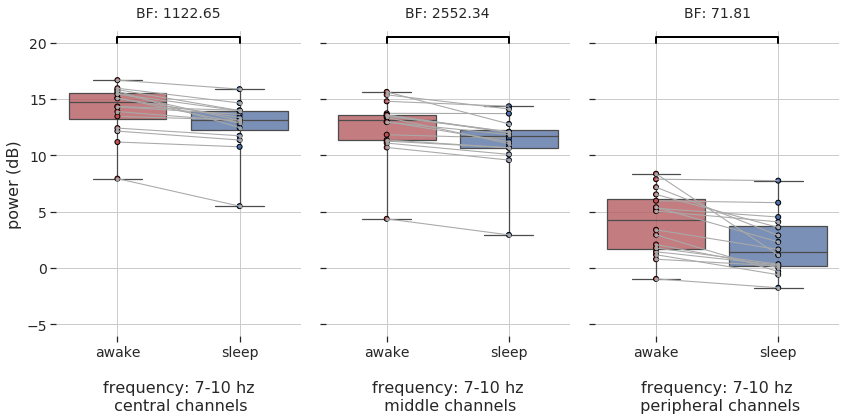

In [101]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(12, 6))

sns.pointplot(x="type",y="power",hue='dataset',data=group_roi1_df,ax=ax1, dodge=0.0,
                    palette=['darkgray'])

sns.boxplot(x="type",y="power",data = group_roi1_df, whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = typepal)

sns.stripplot(x="type",y="power",data = group_roi1_df, jitter=False, linewidth=1, ax=ax1,
              edgecolor ="black",palette=typepal)

string_val1 = 'BF: ' + str(np.round(float(resroi1_df['BF10'].values[0]),2)) + "\n"
#               "\nCohens'd: " + str(np.round(cohens_d1,2))
              

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 20.0, text = string_val1)


ax1.legend_.remove()
b = list(ax1.get_children())

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.set_ylabel('power (dB)', fontsize=label_fontsize)
ax1.set_xlabel('\nfrequency: 7-10 hz\n central channels', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)


sns.pointplot(x="type",y="power",hue='dataset',data=group_roi2_df,ax=ax2, dodge=0.0,
                    palette=['darkgray'])

sns.boxplot(x="type",y="power",data = group_roi2_df, whis=np.inf, ax=ax2, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = typepal)
sns.stripplot(x="type",y="power",data = group_roi2_df, jitter=False, linewidth=1, ax=ax2,
              edgecolor ="black",palette=typepal)

string_val2 = 'BF: ' + str(np.round(float(resroi2_df['BF10'].values[0]),2)) + "\n"
#               "\nCohens'd: " + str(np.round(cohens_d2,2))

statannotation(ax = ax2, x1 = 0, x2 = 1, y = 20.0, text = string_val2)


ax2.legend_.remove()
b = list(ax2.get_children())

for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax2.set_ylabel('', fontsize=label_fontsize)
ax2.set_xlabel('\nfrequency: 7-10 hz\n middle channels', fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax2.grid(True)



sns.pointplot(x="type",y="power",hue='dataset',data=group_roi3_df,ax=ax3, dodge=0.0,
                    palette=['darkgray'])

sns.boxplot(x="type",y="power",data = group_roi3_df, whis=np.inf, ax=ax3, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = typepal)
sns.stripplot(x="type",y="power",data = group_roi3_df, jitter=False, linewidth=1, ax=ax3,
              edgecolor ="black",palette=typepal)

string_val3 = 'BF: ' + str(np.round(float(resroi3_df['BF10'].values[0]),2)) + "\n"
#               "\nCohens'd: " + str(np.round(cohens_d3,2))

statannotation(ax = ax3, x1 = 0, x2 = 1, y = 20.0, text = string_val3)


ax3.legend_.remove()
b = list(ax3.get_children())

for patch in ax3.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax3.set_ylabel('', fontsize=label_fontsize)
ax3.set_xlabel('\nfrequency: 7-10 hz\n peripheral channels', fontsize=label_fontsize)
ax3.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax3.grid(True)

ax1.set_ylim([-6, 21])

plt.tight_layout()
plt.box(False)

# plt.savefig(outputfolderpath +  'roi_awake_sleep_spectogram_stats_01.png', format='png', dpi=300, 
#             transparent=False, bbox_inches='tight')